# Displacement surge models

Will there be a displacement crisis for country x this/next year? We look to answer this question by treating it as a classification problem. A crisis is defined if displacement surges beyond a certain threshold. Looking at data from 25 countries, we train a classifier to predict if there will be a surge or not.


In [1]:
import os
import json
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")

In [2]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join("..", config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if d['name']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in wide form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))


subglobal = ['SYR','COL','AFG','COG','SSD','SOM','VEN','ETH','SDN','NGA',
             'IRQ','YEM','UKR','MMR','CAF','CMR','ERI','BDI','GEO','MLI',
             'TCD','LBY','NER','BFA','COD']
# data filtering

# Spatial filter
c1 = data['Country Code'].isin(subglobal)

# Temporal filter
c2 = data['year'] >= 1980


data = data[c1 & c2]
print("Filtered data of size  : {} (rows) {} (columns)".format(*data.shape))


# Get a look up table of indicators to use for the explainer
grp = (df
        .groupby(['Indicator Code', 'Indicator Name'])['year']
        .count()
        .reset_index()
        .drop(columns='year')
        .set_index('Indicator Code').to_dict())

INDICATORS = grp['Indicator Name']

Sources            : 19
Shape              : 924558 (rows) 6 (columns)
Geographies        : 568
Indicators         : 142
Temporal coverage  : 1789 -> 2019
Null values        : 1421

Loaded data in 1.36 sec.
Long form of size  : 35901 (rows) 144 (columns)
Filtered data of size  : 1000 (rows) 144 (columns)


In [3]:
data.head()

Indicator Code,Country Code,year,ACLED.COUNT,ACLED.FATALITIES,ADESA,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,DRC.TOT.DISP,EG.ELC.ACCS.ZS,EMDAT.CPX.OCCURRENCE,...,WHO.EXT.HTLTH.EXP,WHO.INF.DTH,WHO.MAT.DEATHS,WHO.MAT.MORT.RATIO,WHO.NEO.DTH,WHO.NUM.TB.CAS,WHO.OOP.HLTH.EXP,WHO.TB.CAS,WHO.TB.TMT.COV,WHO.UND.FIV.DTH
266,AFG,1980,NaN,NaN,NaN,78.64,70.84,1734921.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,AFG,1981,NaN,NaN,NaN,78.45,72.86,3879984.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,AFG,1982,NaN,NaN,NaN,77.60,73.31,4488214.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,AFG,1983,NaN,NaN,NaN,75.83,71.89,4712735.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,AFG,1984,NaN,NaN,NaN,72.97,68.09,4417651.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Target variable

What constitutes a surge.

- Will there be a high number of displacement. 



In [3]:
# Binary outcomes (displacement or no displacement) based on 
# if total *new* displacement for the year exceeds this threshold

NEW_DISP_THRESHOLD = 75000
PER_100K_THRESHOLD = 500

def target_outcomes(x):
    
    x = x.sort_values(by='year')
    x.set_index('year', inplace=True)
    new_stock = x['DRC.TOT.DISP'].diff()
    return new_stock
    
# Compute new displacements
d = data.groupby(['Country Code']).apply(target_outcomes)
tar = d.reset_index().melt(id_vars=['Country Code'], value_vars=d.columns)
tar.rename(columns={'value': 'TARGET'}, inplace=True)
data = data.merge(right=tar, on=['Country Code', 'year'])

# Report on the top 10 countries
tmp = data.set_index(['Country Code', 'year'])
x = tmp.loc[~pd.isnull(tmp['TARGET']), 'TARGET']
x = x.sort_values(ascending=False)
print(x.head(10))

c1 = data.TARGET > NEW_DISP_THRESHOLD
print("#Surge events based on new displacement exceeding {:,}: {}".format(NEW_DISP_THRESHOLD, sum(c1)))

c2 =  (100000 * data.TARGET/data["SP.POP.TOTL"]) > PER_100K_THRESHOLD
print("#Surge events based on per-capita displacement {:,}: {}".format(PER_100K_THRESHOLD, sum(c2)))

data['TARGET'] = c1 # | c2
print("Total #surge events: {}".format(sum(data.TARGET)))

# Does Myanmar meet the criteria?
if data.set_index(['Country Code', 'year']).loc[('MMR', 2017), 'TARGET']:
    print("Myanmar 2017 categorized as a surge.")
else:
    print("Myanmar 2017 not considered a surge.")

Country Code  year
SYR           2013    5256824.0
SDN           2009    4847339.0
NGA           2013    3320316.0
SYR           2012    3113448.0
VEN           2018    2575366.0
SYR           2014    2555257.0
COD           2017    2388016.0
YEM           2015    2195572.0
AFG           1981    2145063.0
COD           2009    1982705.0
Name: TARGET, dtype: float64
#Surge events based on new displacement exceeding 75,000: 153
#Surge events based on per-capita displacement 500: 146
Total #surge events: 153
Myanmar 2017 categorized as a surge.


# Features

Two variants: We can consider *all* features from the dataset or just the ones used by the causal model. 

In [4]:
# Variant 1: All features
idx = ['Country Code', 'year']
mm = ['ETH.TO.{}'.format(i) for i in ['DNK', 'GBR', 'ITA', 'SAU', 'SWE', 'ZAF']]
endo = ['UNHCR.OUT.AS', 'UNHCR.OUT.IDP', 'UNHCR.OUT.OOC', 
        'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.RETIDP', 'IDP', "UNHCR.EDP"]
# missing entirely
emdat = ['EMDAT.CPX.OCCURRENCE','EMDAT.CPX.TOTAL.DEATHS','EMDAT.CPX.TOTAL.AFFECTED','EMDAT.CPX.AFFECTED']

# low coverage
low_cov = ['UC.FAT.RAKH',
'UC.EVT.RAKH',
'WFP.PRC.WHT',
'ER.GDP.FWTL.M3.KD',
'WHO.MAT.MORT.RATIO',
'WHO.MAT.DEATHS',
'SE.ADT.LITR.ZS',
'SI.POV.GINI',
'ER.H2O.INTR.PC',
'IQ.CPA.PROP.XQ',
'EN.ATM.PM25.MC.M3']
target = ['DRC.TOT.DISP', 'TARGET']
allfeatures = list(set(data.columns.tolist()) - set(idx + mm + endo + target + emdat))

mmr_data = [f for f in allfeatures if f.startswith('MMR.NSO')]

features =  list(set(allfeatures) - set(mmr_data))
print("# Features: {}".format(len(features)))

# Features: 110


In [31]:
# Variant 2: a subset

"""with open("../model/bayesnetwork/network.json", 'rt') as infile:
    net = json.load(infile)
features = [i['code'] for i in net['indicators']]
features.remove('DRC.TOT.DISP')
print("# Features: {}".format(len(features)))
"""

# Features: 15


# Some pre-processing

The target variable is highly-imbalanced. So resample with replacement to balance the classes. But first remove the test set. 

In [5]:
data.TARGET.value_counts()

False    847
True     153
Name: TARGET, dtype: int64

In [6]:
target = 'TARGET'
X = data[features].dropna(how='all', axis=1)
y = data[target]

# Random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

print("Training set: {} obs {} features".format(*X_train.shape))
print("Testing set : {} obs {} features".format(*X_test.shape))

Training set: 800 obs 110 features
Testing set : 200 obs 110 features


In [7]:
# OR Time-base splits
yr = 2015
target = 'TARGET'
test_idx = data.year > yr
train_idx = ~test_idx
X_train = data.loc[train_idx][features]
X_test = data.loc[test_idx][features]
y_train = data.loc[train_idx][target]
y_test = data.loc[test_idx][target]
print("Training set: {} obs {} features".format(*X_train.shape))
print("Testing set : {} obs {} features".format(*X_test.shape))

Training set: 900 obs 110 features
Testing set : 100 obs 110 features


In [8]:
from imblearn.over_sampling import RandomOverSampler 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
y_train_res.value_counts()

Using TensorFlow backend.
/Users/rahul/anaconda3/envs/mm4sight/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rahul/anaconda3/envs/mm4sight/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rahul/anaconda3/envs/mm4sight/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rahul/a

True     771
False    771
Name: TARGET, dtype: int64

# Models

Let's start with a baseline model - logistic regression.

Accuracy: 74.00%


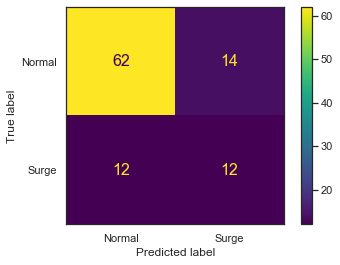

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

clf = Pipeline(steps=[('imputer', SimpleImputer()), 
                      ('preprocessor', StandardScaler()),
                      ('classifier', LogisticRegression(max_iter=500))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Surge'], values_format='.0f');

Accuracy: 76.00%


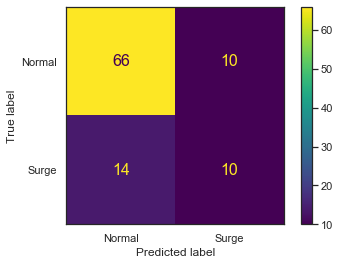

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
clf = Pipeline(steps=[('imputer', SimpleImputer()), 
                      ('preprocessor', StandardScaler()),
                      ('classifier', GradientBoostingClassifier(random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Surge'], values_format='.0f');

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

       False       0.82      0.87      0.85        76
        True       0.50      0.42      0.45        24

    accuracy                           0.76       100
   macro avg       0.66      0.64      0.65       100
weighted avg       0.75      0.76      0.75       100



Perhaps interesting to see:
- can we explain why we can capture a majority of these events?
- this is like a 'nowcast'. How would we do for future year surges?
- Would the Myanmar 2017 case be nowcasted/forecasted?

# Explainer models

In [12]:
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BooleanRuleCG, BRCGExplainer

# AIX360 methods are not valid estimators/transformers
# So can't be used in a pipeline. First impute
imp = SimpleImputer()
X_train_fb = pd.DataFrame(imp.fit_transform(X_train))
X_train_fb.columns = X_train.columns

X_test_fb = pd.DataFrame(imp.transform(X_test))
X_test_fb.columns = X_test.columns

fb = FeatureBinarizer(negations=True)
X_train_fb = fb.fit_transform(X_train_fb)
X_test_fb = fb.transform(X_test_fb)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(true, pred, display_labels):
    """ plot confusion for non-estimators """
    
    cm  = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    
    return disp.plot(include_values=True,
                     cmap='viridis', ax=None, xticks_rotation=None,
                     values_format='.0f')

In [ ]:
# Note that the explanations are sensitive to the regularization parameters
boolean_model = BooleanRuleCG(silent=False, lambda0=0.001, lambda1=0.001, CNF=True)
explainer = BRCGExplainer(boolean_model)
explainer.fit(X_train_fb, y_train)

y_pred = explainer.predict(X_test_fb)
print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_cm(y_test, y_pred, [False, True]);

In [ ]:
print(classification_report(y_test, y_pred));

In [ ]:
import re
pattern = re.compile(r'\b(' + '|'.join(INDICATORS.keys()) + r')\b')
e = explainer.explain()

# the labels are flipped between Conjunctive/Disjunctive normal forms
isCNF = 'No surge if ANY of the following rules are satisfied, otherwise predict surge:'
notCNF = 'Predict surge if ANY of the following rules are satisfied, otherwise no:'
print(isCNF if e['isCNF'] else notCNF)
print()
for rule in e['rules']:
    result = pattern.sub(lambda x: INDICATORS[x.group()], rule)
    print(f'  - {result}')

## Misclassifications

Which instances were incorrectly classified?

In [14]:
from pprint import pprint

print("Misclassifications: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p != t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        tst = 'Surge' if t else 'Normal'
        try:
            res[ccode].append("{}->{}".format(yr, tst))
        except KeyError:
            res[ccode] = ["{}->{}".format(yr, tst)]
            
pprint(res)

        
print("\nCorrectly classified: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p == t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        tst = 'Surge' if t else 'Normal'
        try:
            res[ccode].append("{}->{}".format(yr, tst))
        except KeyError:
            res[ccode] = ["{}->{}".format(yr, tst)]
pprint(res)

Misclassifications: 
{'AFG': ['2017->Normal'],
 'CAF': ['2017->Surge'],
 'CMR': ['2016->Normal', '2017->Surge', '2018->Surge'],
 'COD': ['2016->Surge', '2017->Surge'],
 'COG': ['2017->Surge'],
 'ETH': ['2017->Surge', '2018->Surge'],
 'GEO': ['2017->Surge'],
 'LBY': ['2016->Normal', '2017->Normal'],
 'MLI': ['2018->Surge'],
 'NGA': ['2017->Normal', '2018->Surge'],
 'SOM': ['2017->Normal', '2018->Surge'],
 'SSD': ['2018->Normal'],
 'SYR': ['2018->Normal'],
 'VEN': ['2017->Surge', '2018->Surge'],
 'YEM': ['2016->Normal', '2017->Normal']}

Correctly classified: 
{'AFG': ['2016->Surge', '2018->Surge', '2019->Normal'],
 'BDI': ['2016->Normal', '2017->Normal', '2018->Normal', '2019->Normal'],
 'BFA': ['2016->Normal', '2017->Normal', '2018->Normal', '2019->Normal'],
 'CAF': ['2016->Normal', '2018->Normal', '2019->Normal'],
 'CMR': ['2019->Normal'],
 'COD': ['2018->Normal', '2019->Normal'],
 'COG': ['2016->Normal', '2018->Normal', '2019->Normal'],
 'COL': ['2016->Surge', '2017->Normal', '2018->

# Next year forecast

The above is for `current` year. How do we do for classifications for year `t + 1`?


In [15]:
def lag_variables(data, var, lag):

    idx_cols = ['year', 'Country Code']
    fv = var + idx_cols
    
    tmp = data[fv].copy(deep=True)
    
    col_name = [v + ".T" + "{0:+}".format(lag) for v in var]
    
    tmp.rename(columns={k: v for (k, v) in zip(var, col_name)},
               inplace=True)
    tmp.year -= lag
    data = pd.merge(data, tmp, on=idx_cols, how='left')
    
    return data, col_name

data2, vname = lag_variables(data, ['TARGET'], 1)
data2['TARGET'] = data2[vname]

# Drop unknown labels
#data2 = data2.dropna(subset=['TARGET'])

Accuracy: 72.80%


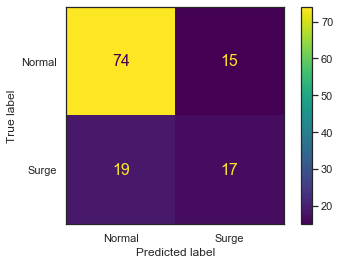

In [16]:
target = 'TARGET'
X = data2[features].dropna(how='all', axis=1)
y = data2[target]

# Drop missing labels
idx = ~y.isnull()
X = X.loc[idx]
y = y.loc[idx]
#y.loc[y.isnull()] = False

# Random splits
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# OR Time-base splits
yr = 2014
test_idx = data.year > yr
train_idx = ~test_idx
X_train = data.loc[train_idx][features]
X_test = data.loc[test_idx][features]
y_train = data.loc[train_idx][target]
y_test = data.loc[test_idx][target]

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
y_train_res.value_counts()


clf = Pipeline(steps=[('imputer', SimpleImputer()), 
                      ('preprocessor', StandardScaler()),
                      ('classifier', GradientBoostingClassifier(random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Surge'], values_format='.0f');

In [17]:
from pprint import pprint

print("Misclassifications: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p != t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        tst = 'Surge' if t else 'Normal'
        try:
            res[ccode].append("{}->{}".format(yr, tst))
        except KeyError:
            res[ccode] = ["{}->{}".format(yr, tst)]
            
pprint(res)

        
print("\nCorrectly classified: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p == t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        tst = 'Surge' if t else 'Normal'
        try:
            res[ccode].append("{}->{}".format(yr, tst))
        except KeyError:
            res[ccode] = ["{}->{}".format(yr, tst)]
pprint(res)

Misclassifications: 
{'AFG': ['2017->Normal', '2018->Surge'],
 'BDI': ['2015->Surge'],
 'CAF': ['2015->Normal', '2016->Normal'],
 'CMR': ['2015->Surge', '2017->Surge', '2018->Surge'],
 'COD': ['2016->Surge', '2017->Surge'],
 'COG': ['2017->Surge'],
 'COL': ['2017->Normal'],
 'ERI': ['2016->Normal'],
 'ETH': ['2016->Normal', '2017->Surge', '2018->Surge'],
 'GEO': ['2017->Surge'],
 'IRQ': ['2015->Normal', '2016->Normal', '2017->Normal'],
 'LBY': ['2016->Normal', '2017->Normal'],
 'MLI': ['2018->Surge'],
 'NER': ['2015->Surge'],
 'NGA': ['2015->Surge', '2018->Surge'],
 'SOM': ['2017->Normal', '2018->Surge'],
 'SYR': ['2018->Normal'],
 'UKR': ['2015->Surge'],
 'VEN': ['2017->Surge', '2018->Surge'],
 'YEM': ['2016->Normal', '2017->Normal']}

Correctly classified: 
{'AFG': ['2015->Surge', '2016->Surge', '2019->Normal'],
 'BDI': ['2016->Normal', '2017->Normal', '2018->Normal', '2019->Normal'],
 'BFA': ['2015->Normal',
         '2016->Normal',
         '2017->Normal',
         '2018->Normal',


In [170]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

       False       0.90      0.98      0.94        91
        True       0.92      0.71      0.80        34

    accuracy                           0.90       125
   macro avg       0.91      0.84      0.87       125
weighted avg       0.91      0.90      0.90       125



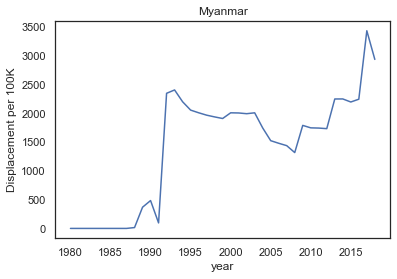

In [133]:
idx = data['Country Code'] == 'MMR'

# y = 100000 * data['DRC.TOT.DISP'] / data["SP.POP.TOTL"]
y = 100000 * data['DRC.TOT.DISP'] / data["SP.POP.TOTL"]


plt.plot(data.loc[idx, 'year'], y[idx])
plt.xlabel('year')
plt.ylabel("Displacement per 100K")
plt.title('Myanmar');